## 2. Preprocessing

After having a look at the data, we now want to pre-process them for our algorithms. To do such a thing, we know that data have to be clean and well scale in order to maximize the learning of  model : <span style="color: yellow"> garbage in garbage out ! </span>

The different steps we have planned are :
- **Scales features** : use of zcore as usual
- **Treate Outliers** : none normally
- **Dataset splitting** : cross validation and test set
- **Features selection** : see correlation and real impact via filter/wrapper methods and dimensionality reduction 

In [1]:
# Classical libraries
import numpy as np
import pandas as pd
import sklearn
from scipy.stats import zscore

### Data Pre-processing

Before starting anything, let us check if is not any missing value in our dataset

In [2]:
# load data and verify none data
#dataset = pd.read_excel('Needs.xls', index_col=0)
%store -r dataset
np.any(np.isnan(dataset.values))

False

There is not, we can continue. Now, we have to do the log transformation as we have seen before.

In [3]:
# log transformation as we have seen 
#logIncome = np.log(dataset[["Income"]].values)
#logWealth = np.log(dataset[["Wealth"]].values)
#dataset["logIncome"] = logIncome
#dataset["logWealth"] = logWealth
#dataset = dataset.drop(["Income", "Wealth" ], axis=1)

Then, we normalise our data with the z-score technique.

In [4]:
#we convert it into a numpay array
data = dataset[["Age","Gender", "FamilyMembers", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth"]].values

#we store mean and std before use z-score scaler
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
X =  zscore(data) # scale data

# COMMENT FAIRE POUR LES VARIABLES CORRÉLLÉES ??????

And for finish, we get the targets

In [5]:
# we store the target
t_inc = dataset['IncomeInvestment'].values == 1
t_acc = dataset['AccumulationInvestment'].values == 1

Now, we split our dataset, randomly, into two subset: The training set (with 85% of the datas) and the Test set (with 15% of the datas).

In [6]:
from sklearn.model_selection import train_test_split

#Train = 85% % ; Test = 15 %
X_train, X_test, Inc_train, Inc_test, Acc_train, Acc_test = train_test_split(X, t_inc, t_acc, test_size=0.15, shuffle=True, random_state=0)

Now we have all our data pre-processes, we want to see the impact of different feature. We assume to have good computational ressources but will try to minimize the cost when we can.

### Features Pre-processing

**<span style="color: green"> Idea : </span>** We are going to first use filtration methods on our feature. This allow us to rank them subject to differents metrics. This is usefull but can neglect correlation or complex  objective function so this is just a first step. 

In addition, we will use wrapper methods. Backward to confirm or affirm result get from filtration. We are also going to see some feature importance (a bit of interpretability) to have a first real explanation on how can be modeled our data. 

To do so, we will simples model that allow interpretability and and a reasonable computational cost. We have choser a KNN (easier one) and a random forest (a bit more evolved in order to have less bias)

To conclude, we of course need to process a PCA as it is done for this.



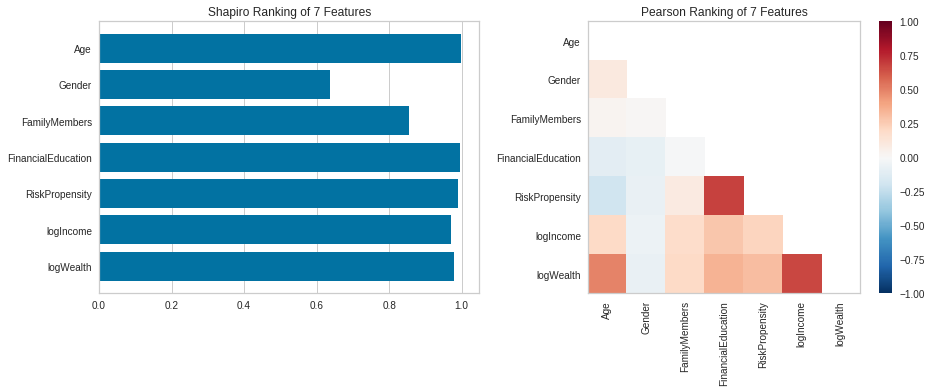

In [7]:
# first : filtration method
from yellowbrick.features import rank1d, rank2d
import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 2, figsize=(15,5))
rank1d(dataset.drop(["IncomeInvestment", "AccumulationInvestment" ], axis=1), ax=axes[0], show=False)
rank2d(dataset.drop(["IncomeInvestment", "AccumulationInvestment" ], axis=1), ax=axes[1], show=False)
plt.show()

It's quite hard to understand perfectly the shapiro ranking but it can be seen as a ranking on variability, stationnary, relation with output things like this between feature. It can be biased but give some information. Correlation rank is obvious.

We can see that as expected, familymember and gender have a lowest importance than the other. Gender is clearly not correlated with others features and confirm the well distributed fact over the others features, making it useless in our point of view 

We also see again the correlation between RiskPropensity and financialEducation, and logIncome and logWealth, that may be very important features to explain  the model.

Another point that confirm our idea about the fact that age is more relevant than familyMember is that we can see a correlation between age and wealth (obvious when we think so). Thus we think age will give more information in differents model than familyMembers.

The correlation between Income and Wealth can also be obvisous since more income lead to bigger wealth. 

Let's now train a simple model to do a Backward approach, to validate this observation

We base it on the accuracy since it is simple to have it and an easy interpretable score, but we will see later that others metrics are more relevant for our problem


# ON A 2 MATRICE DE CORRELATION ET LE SHARPIO RANKING POSE PB

In [8]:
# Backward wrapper method
#from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RF

#feature order : 
#["Age", "Gender", "FamilyMembers", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth"]
#  0       1                 2                 3                4                 5        6
classes = {0:"Age", 1:"Gender", 2:"FamilyMembers", 3:"FinancialEducation", 4:"RiskPropensity", 5:"logIncome", 6: "logWealth", 7:"IncomeInvestment", 8:"AccumulationInvestment"}
nb_classes = np.shape(X)[1]

# on accumulation investment :
Accu =RF()
Accu.fit(X_train, Acc_train)
print("full accuracy for accumulation: ", Accu.score(X_test, Acc_test))
#accuracies = []
for i in range(nb_classes):
    list = [j for j in range(nb_classes) if j!=i]
    Accu_i = RF()
    Accu_i.fit(X_train[:,list], Acc_train)
    #accuracies.append(Accu.score(X_test[:,list], Acc_test))
    print("without ", classes[i], "and with the rest", Accu_i.score(X_test[:,list], Acc_test))

# on Income investment :
Inc =RF()
Inc.fit(X_train, Inc_train)
print("\nfull accuracy for Income: ", Inc.score(X_test, Inc_test))
for i in range(nb_classes):
    list = [j for j in range(nb_classes) if j!=i]
    Inc_i = RF()
    Inc_i.fit(X_train[:,list], Inc_train)
    #accuracies.append(Accu.score(X_test[:,list], Acc_test))
    print("without ", classes[i], "and with the rest", Inc_i.score(X_test[:,list], Inc_test))

full accuracy for accumulation:  0.784
without  Age and with the rest 0.7573333333333333
without  Gender and with the rest 0.792
without  FamilyMembers and with the rest 0.8013333333333333
without  FinancialEducation and with the rest 0.7786666666666666
without  RiskPropensity and with the rest 0.7853333333333333
without  logIncome and with the rest 0.6626666666666666
without  logWealth and with the rest 0.6733333333333333

full accuracy for Income:  0.8013333333333333
without  Age and with the rest 0.7866666666666666
without  Gender and with the rest 0.8026666666666666
without  FamilyMembers and with the rest 0.804
without  FinancialEducation and with the rest 0.8
without  RiskPropensity and with the rest 0.8
without  logIncome and with the rest 0.764
without  logWealth and with the rest 0.7186666666666667


In [9]:
#Forward Stepwise Selection

datas, datasTest = [], []
features = [5, 1, 2, 0, 3, 4, 6]
indexFeat, accTotal = [], []
for step_i in range(len(features)):
    accMax, ind = -1, features[0]
    for index in features:
        feat, featTest = X_train[:,index], X_test[:,index]
        train = np.array((datas + [feat]))
        test = np.array((datasTest + [featTest]))
        Inc_RF = None
        Inc_RF = RF()
        Inc_RF.fit(train.transpose(), Inc_train)
        acc = Inc_RF.score(test.transpose(), Inc_test)
        if accMax < acc:
            accMax = acc
            ind = index
        print(classes[index], " has ", acc)
    indexFeat.append(ind)
    print("Index feature : ", indexFeat, " accuracy = ", accMax)
    print("")
    accTotal.append(accMax)
    datas += [X_train[:,ind]]
    datasTest += [X_test[:,ind]]
    features.remove(ind)


logIncome  has  0.54
Gender  has  0.6186666666666667
FamilyMembers  has  0.6146666666666667
Age  has  0.7053333333333334
FinancialEducation  has  0.5426666666666666
RiskPropensity  has  0.54
logWealth  has  0.6266666666666667
Index feature :  [0]  accuracy =  0.7053333333333334

logIncome  has  0.6453333333333333
Gender  has  0.7026666666666667
FamilyMembers  has  0.7013333333333334
FinancialEducation  has  0.6266666666666667
RiskPropensity  has  0.62
logWealth  has  0.68
Index feature :  [0, 1]  accuracy =  0.7026666666666667

logIncome  has  0.644
FamilyMembers  has  0.6933333333333334
FinancialEducation  has  0.636
RiskPropensity  has  0.6293333333333333
logWealth  has  0.6866666666666666
Index feature :  [0, 1, 2]  accuracy =  0.6933333333333334

logIncome  has  0.6893333333333334
FinancialEducation  has  0.6493333333333333
RiskPropensity  has  0.6706666666666666
logWealth  has  0.7093333333333334
Index feature :  [0, 1, 2, 6]  accuracy =  0.7093333333333334

logIncome  has  0.792


In [10]:
#Forward Stepwise Selection for AccumulationInvestment

datas, datasTest = [], []
features = [5, 0, 2, 4, 6]
indexFeat, accTotal = [], []
for step_i in range(len(features)):
    accMax, ind = -1, features[0]
    for index in features:
        feat, featTest = X_train[:,index], X_test[:,index]
        train = np.array((datas + [feat]))
        test = np.array((datasTest + [featTest]))
        Acc_RF = None
        Acc_RF = RF()
        Acc_RF.fit(train.transpose(), Inc_train)
        acc = Acc_RF.score(test.transpose(), Inc_test)
        if accMax < acc:
            accMax = acc
            ind = index
        print(classes[index], " has ", acc)
    indexFeat.append(ind)
    print("Index feature : ", indexFeat, " accuracy = ", accMax)
    print("")
    accTotal.append(accMax)
    datas += [X_train[:,ind]]
    datasTest += [X_test[:,ind]]
    features.remove(ind)

logIncome  has  0.54
Age  has  0.7053333333333334
FamilyMembers  has  0.6146666666666667
RiskPropensity  has  0.54
logWealth  has  0.6266666666666667
Index feature :  [0]  accuracy =  0.7053333333333334

logIncome  has  0.644
FamilyMembers  has  0.7013333333333334
RiskPropensity  has  0.612
logWealth  has  0.6813333333333333
Index feature :  [0, 2]  accuracy =  0.7013333333333334

logIncome  has  0.6613333333333333
RiskPropensity  has  0.6506666666666666
logWealth  has  0.7
Index feature :  [0, 2, 6]  accuracy =  0.7

logIncome  has  0.796
RiskPropensity  has  0.7653333333333333
Index feature :  [0, 2, 6, 5]  accuracy =  0.796

RiskPropensity  has  0.8
Index feature :  [0, 2, 6, 5, 4]  accuracy =  0.8



**Statement :**  <span style="color: red"> question prof !!: </span> pourquoi avec KNN ca augmente ? Pourquoi sinon des feature aussi important que FE ne change pa sla donne ? 

It can happen but here it look strange. Maybe the problem is KNN, in this case best algo are tree oor other

Some weigth of Logistic regression can help us to validate this :

0.66
0.764


<BarContainer object of 7 artists>

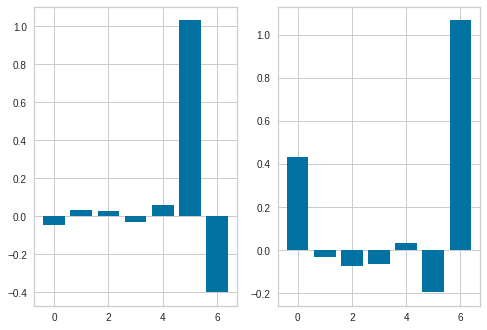

In [11]:
from sklearn.linear_model import LogisticRegression as LG

fig, axis = plt.subplots(1, 2)
Accu = LG()
Accu.fit(X_train, Acc_train)
print(Accu.score(X_test, Acc_test))
importance = Accu.coef_.flatten()
axis[0].bar([x for x in range(len(importance))], importance)

Inc = LG()
Inc.fit(X_train, Inc_train)
print(Inc.score(X_test, Inc_test))
importance = Inc.coef_.flatten()
axis[1].bar([x for x in range(len(importance))], importance)


With simple model, we can thus confirm our idea.
We have to be aware that this is maybe biased since big feature seems not important sometimes, and this look weird.

Let's see thus with a litle bit more complex model, to reduce the bias : a random forest.
We train it without optimize it but it still relevant for us. We want to compute feature importance that part for interpretability in order to optimize in future model the use of our feature

In [12]:
# fct to plot feature importance, will use it for accumulation and income investment
from sklearn.ensemble import RandomForestClassifier as RF
import seaborn as sns
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

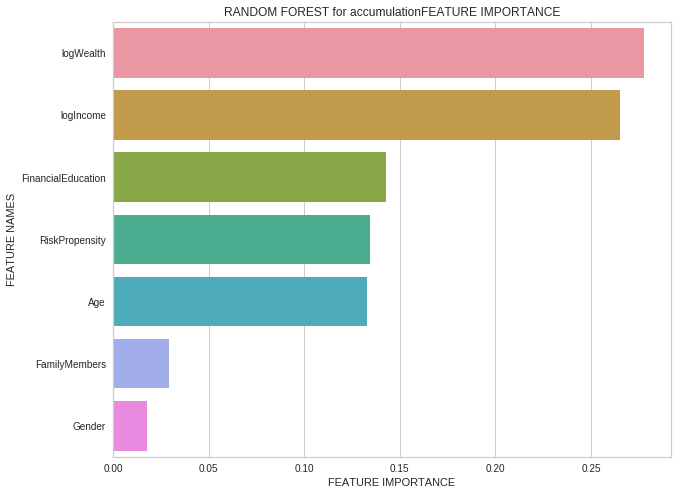

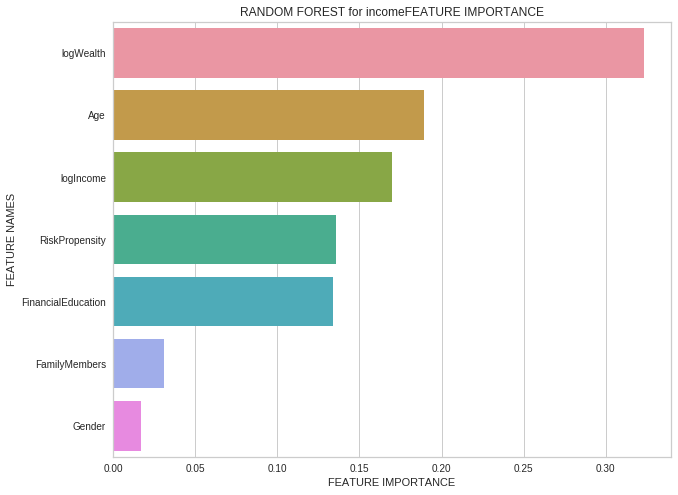

In [13]:
# order of our features
c = ["Age", "Gender", "FamilyMembers", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth"]
#random forest classifier
AccumulationRF = RF()
IncomeRF = RF()
AccumulationRF.fit(X_train, Acc_train)
IncomeRF.fit(X_train, Inc_train)
plot_feature_importance(AccumulationRF.feature_importances_, c,'RANDOM FOREST for accumulation')
plot_feature_importance(IncomeRF.feature_importances_, c,'RANDOM FOREST for income')

As we can see, FamilyMembers and Gender doesn't seems to play a big role in our model. This is what we was expected to have and with the different methods we have used, we are quite certain of our result.

Others features were important for us and in this last technique it is proove to be just. All seems to have a importance non-negligeable. 

We thus can train model with 5 feature instead of 7. The gap isn't huge but it is more for business interpretation. We also avoid overfiting by reducing the problem.

This last part is dedicated to the PCA method. As you will see, there will be 5 PC that account for a large amount of variance. This is quite huge because doing PCA we were expected to reduce the problem to dimension 2 or at least 3 in order to have better visualization and reduction of the problem.

Thus we will not use the PC space because it doesn't simplify the case as we already avoid the two feature by our interpretation

Here the PCA :

first principal component direction: [-0.17971306  0.62566066 -0.24773785 -0.17613875  0.54687962 -0.02570478
  0.42908624]
explained variance: [2.36049346 1.55590155 0.98727369 0.97728577 0.60680364 0.30258578
 0.20129939]


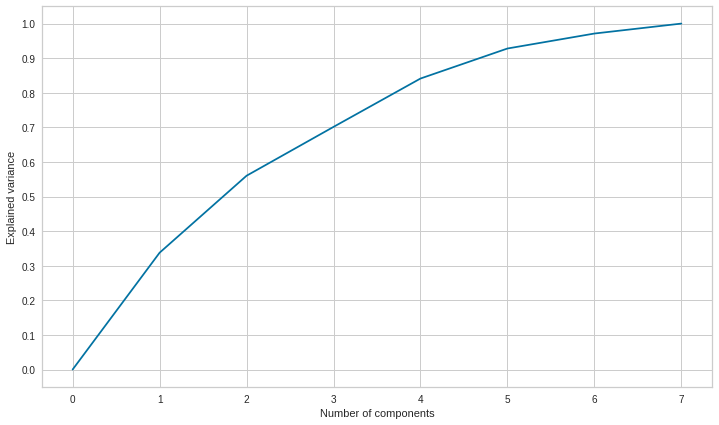

In [14]:
# PCA
from sklearn.decomposition import PCA
pca = PCA()
# we fit the dataset 
pca.fit(X_train)
# we extract the principal components directions
print('first principal component direction:', pca.components_[:,0])

# and the corresponding explained variance
explained = pca.explained_variance_
print('explained variance:', explained)

#transform into PC space
T = pca.transform(X_train)

explained_variance = np.cumsum(explained) / sum(explained)
explained_variance = np.insert(explained_variance, 0, 0.)

plt.figure(figsize=(12,7))
plt.plot(range(len(explained_variance)), explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.xticks(range(len(explained_variance)))
plt.yticks(np.arange(0., 1.1, 0.1))
plt.show()

We can see that the problem isn't really simplier in the PC space. In fact, we would have choose the 5 first, deleting the last two that account just for less than 5%. 

For exemple, let's plot somme data in the most important pc space and see that there is still no really clear way of classificate data :

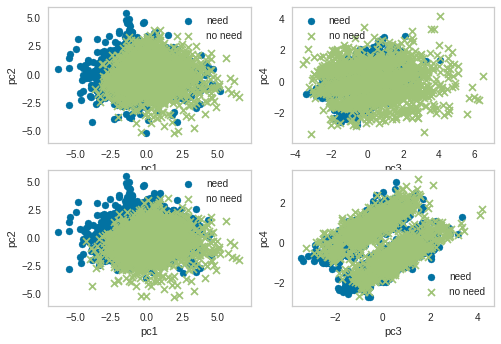

In [15]:
need = T[Acc_train==1]
no_need = T[Acc_train==0]
need_inc = T[Inc_train==1]
no_need_inc = T[Inc_train==0]
fig, axis = plt.subplots(2, 2)

axis[0,0].scatter(need[:, 0], need[:, 1], label='need')
axis[0,0].scatter(no_need[:, 0], no_need[:, 1], label='no need', marker='x')
axis[0,0].set(xlabel='pc1', ylabel='pc2')
axis[0,0].grid()
axis[0,0].legend()

axis[0,1].scatter(need[:, 2], need[:, 3], label='need')
axis[0,1].scatter(no_need[:, 0], no_need[:, 2], label='no need', marker='x')
axis[0,1].set(xlabel='pc3', ylabel='pc4')
axis[0,1].grid()
axis[0,1].legend()

axis[1,0].scatter(need_inc[:, 0], need_inc[:, 1], label='need')
axis[1,0].scatter(no_need_inc[:, 0], no_need_inc[:, 1], label='no need', marker='x')
axis[1,0].set(xlabel='pc1', ylabel='pc2')
axis[1,0].grid()
axis[1,0].legend()

axis[1,1].scatter(need_inc[:, 2], need_inc[:, 3], label='need')
axis[1,1].scatter(no_need_inc[:, 2], no_need_inc[:, 3], label='no need', marker='x')
axis[1,1].set(xlabel='pc3', ylabel='pc4')
axis[1,1].grid()
axis[1,1].legend()

plt.show()

Even in the two most component there is no a real separation, a real way such that we can easly explain our data.

This end our data selection.

## <span style="color: green"> Summary: </span> 

We have shown that our knowledge on the subject can be shown explorating the data. But this is not enough to validate some aprioris and to generalize it to all future dataset. 

We have thus shown that with some simple metric and model we can model these knowledge and with a known bias interpret the output of it. 

We are thus almost sure that the features FamilyMembers and Gender aren't relevant for our problem and thus we can remove them before doing complex modelisation. 

This can help us to avoid doing overfitting. Also, it reduce the computational cost. And finally we use the principe of parsimony in the financial way : keep as less as feature needed meaning they have importance and business interpretation.

In [16]:
print(X[:,[0, 3, 5, 6]])

[[ 0.3965249  -1.25810967  0.43594276 -0.19032344]
 [ 1.90022192 -0.39774749 -0.98517827  0.82349206]
 [-1.85902062 -0.67125887 -0.90518442  0.04741566]
 ...
 [ 0.06237001  0.09714001  0.19273109 -0.00317605]
 [-0.35532361  0.92932441  0.32793655  0.44179201]
 [ 0.98129597 -0.23513582 -0.41968401  0.1651763 ]]


In [19]:
#Final feature selection
X_inc = X[:,[0, 2, 3, 4, 5, 6]]  # => ["Age", "FamilyMembers", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth"]
X_acc = X[:,[0, 3, 5, 6]] # => ["Age", "FinancialEducation", "logIncome", "logWealth"]

%store X_inc
%store X_acc
%store t_inc
%store t_acc

Stored 'X_inc' (ndarray)
Stored 'X_acc' (ndarray)
Stored 't_inc' (ndarray)
Stored 't_acc' (ndarray)


We are now ready to train complex models and to provide true performance of ML algorithm in order to solve our problem : match people with their needs